In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from matplotlib import pyplot as plt
from numpy import mean
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, auc, f1_score, precision_score,
                             recall_score, roc_auc_score, silhouette_score)
from sklearn.model_selection import (GridSearchCV, RepeatedStratifiedKFold,
                                     ShuffleSplit, StratifiedShuffleSplit,
                                     cross_val_score)
from sklearn.svm import LinearSVC, SVC
from datetime import datetime

In [2]:
IMAGES_PATH = ""

In [3]:
def concat_two_df_and_drop_same_column_in_df2(DF1, DF2):
    display(DF1.head(1))
    display(DF2.head(1))
    DF2.drop(DF2.columns[DF2.columns.isin(DF1.columns)],axis=1,inplace=True)
#     DF1.drop(DF1.columns[DF1.columns.isin(DF2.columns)],axis=1,inplace=True)
    result = pd.concat([DF1, DF2], axis=1)
    display(result.head(1))
    return result
def count_list_val(arr):
    values, counts = np.unique(arr, return_counts=True)
    print(values, counts)
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [4]:
four_time = pd.read_csv("../CSV/four_time.csv")
v_value = pd.read_csv("../CSV/v_value.csv")
mic = pd.read_csv("../CSV/mic.csv")
dwt_distance = pd.read_csv("../CSV/sdtw_day_score_df.csv")
smart_meter = pd.read_csv("../smart_meter.csv")

In [5]:
fdi = pd.read_csv("../CSV/FDI.csv")

In [6]:
four_time.shape, v_value.shape, mic.shape, dwt_distance.shape, fdi.shape, smart_meter.shape

((2239250, 7),
 (2239250, 9),
 (2239250, 4),
 (2239250, 5),
 (2239250, 3),
 (107484000, 5))

In [7]:
result = concat_two_df_and_drop_same_column_in_df2(fdi, v_value)
result = concat_two_df_and_drop_same_column_in_df2(result, four_time)
result = concat_two_df_and_drop_same_column_in_df2(result, mic)
result = concat_two_df_and_drop_same_column_in_df2(result, dwt_distance)
result.columns

,MeterID,Day,FDI
0,1236,2009-07-15,1.0


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1
0,5212,2010-12-31,True,12,30,15,0.046464,0.047532,0.013561


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561


,MeterID,Day,FDI,overnight,breakfast,daytime,evening
0,1236,2009-07-15,True,5.380015,15.5,24.5,38.0


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0


,MeterID,Day,FDI,mic
0,1236,2009-07-15,True,0.624128


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening,mic
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0,0.624128


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening,mic
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0,0.624128


,MeterID,Day,FDI,meter_dtw,meter_sdtw
0,1236,2009-07-15,True,2.283294,-68.276715


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening,mic,meter_dtw,meter_sdtw
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0,0.624128,2.283294,-68.276715


Index(['MeterID', 'Day', 'FDI', 'Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2',
       'Cmin1', 'overnight', 'breakfast', 'daytime', 'evening', 'mic',
       'meter_dtw', 'meter_sdtw'],
      dtype='object')

In [8]:
df = result
X = df[['overnight', 'breakfast', 'daytime', 'evening',
       'Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2', 'Cmin1', 'mic',
       'meter_dtw', 'meter_sdtw']]
Y = df[["FDI"]]

partition = 422*8*530
evaluation = 422*1*530
total = 2239250


X_train = X[:partition]
X_val = X[partition:total-evaluation]
X_test = X[total-evaluation: total]
y_train = Y[:partition]
y_val = Y[partition:total-evaluation]
y_test = Y[total-evaluation: total]
# y_train = np.array(Y[:partition]).reshape(-1) 
# y_val = np.array(Y[partition:total-evaluation]).reshape(-1) 
# y_test = np.array(Y[total-evaluation: total]).reshape(-1) 

In [9]:
count_list_val(Y)

[0. 1.] [2127950  111300]


### read smart_meter.csv and preprocess

In [10]:
elec = smart_meter['Electricity']
elec = np.array(elec).reshape(-1, 48)
elec = pd.DataFrame(elec)
print(elec.shape)
display(elec.head(3))

(2239250, 48)


,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.13407,0.129562,0.113616,0.18602,0.075942,0.133117,0.062728,0.064174,0.143932,0.142687,...,0.159253,0.154713,0.118059,0.13057,0.118797,0.056694,0.106094,0.08098,0.068501,0.204674
1,0.48300,0.062000,0.035000,0.06800,0.026000,0.013000,0.063000,0.063000,0.013000,0.013000,...,0.138000,0.099000,0.118000,0.16400,0.218000,0.412000,0.253000,0.61000,0.582000,0.292000
2,0.11400,0.041000,0.012000,0.04000,0.067000,0.017000,0.012000,0.064000,0.058000,0.012000,...,0.110000,0.104000,0.164000,0.40100,0.104000,0.138000,0.206000,0.36300,0.526000,0.326000


In [11]:
result = concat_two_df_and_drop_same_column_in_df2(result, elec)
result.columns = result.columns.astype(str)

,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,breakfast,daytime,evening,mic,meter_dtw,meter_sdtw
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,15.5,24.5,38.0,0.624128,2.283294,-68.276715


,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.13407,0.129562,0.113616,0.18602,0.075942,0.133117,0.062728,0.064174,0.143932,0.142687,...,0.159253,0.154713,0.118059,0.13057,0.118797,0.056694,0.106094,0.08098,0.068501,0.204674


,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1,overnight,...,38,39,40,41,42,43,44,45,46,47
0,1236,2009-07-15,1.0,12,30,15,0.046464,0.047532,0.013561,5.380015,...,0.159253,0.154713,0.118059,0.13057,0.118797,0.056694,0.106094,0.08098,0.068501,0.204674


## Start Model Training 

In [12]:
result["FDI"] = result["FDI"].astype(int)

## LinearSVM

In [13]:
def train_model(df, x_col, y_col, score = False, split_num = 3, return_model=False ):
    
    X = df[x_col]
    Y = df[y_col]

    partition = 422*8*530
    evaluation = 422*1*530
    total = 2239250

    round = 1
    average_score = {}
    average_score["precision_score"] = 0
    average_score["recall_score"] = 0
    average_score["accuracy_score"] = 0
    average_score["roc_auc_score"] = 0
    average_score["f1_score"] = 0

    X_train = X[:partition+evaluation]
    y_train = Y[:partition+evaluation]

    sss = StratifiedShuffleSplit(n_splits=split_num, test_size=0.4, random_state=1)
    for train_index, test_index in sss.split(X_train, y_train):
#         test_index = np.concatenate((np.array(test_index), np.array(X[total-(partition+evaluation): total].index)))
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = np.array(Y.iloc[train_index]).reshape(-1) , np.array(Y.iloc[test_index]).reshape(-1)

        model = LinearSVC(max_iter=1000)
        model.fit(X_train, Y_train)
        y_hat = model.predict(X_test)
        average_score["precision_score"] += precision_score(Y_test, y_hat)
        average_score["recall_score"] += recall_score(Y_test, y_hat)
        average_score["accuracy_score"] += accuracy_score(Y_test, y_hat)
        average_score["roc_auc_score"] += roc_auc_score(Y_test, y_hat)
        average_score["f1_score"] += f1_score(Y_test, y_hat)

        if score:
            print("round: " + str(round))
            print("precision score: " + str(precision_score(Y_test, y_hat)))
            print("recall_score: " + str(recall_score(Y_test, y_hat)))
            print("accuracy_score: " + str(accuracy_score(Y_test, y_hat)))
            print("roc_auc_score: " + str(roc_auc_score(Y_test, y_hat)))
            print("f1_score: " + str(f1_score(Y_test, y_hat)))
            print()

        round += 1
    for key, score in average_score.items():
        average_score[key] = score / split_num
        print("average_" + key + ": " + str(average_score[key]))
    if return_model==True:
        return model, average_score
    return average_score

def get_permutation_importance(model, X_val, y_val, title=None, origin=False, save=False):
    
    if save_fig == True and title == None:
        raise NameError('Please type the title for the chart to save')
        
    r = permutation_importance(model, X_val, y_val, n_repeats=30, random_state=0)
    four_time_importance = sum(r.importances_mean[:3])
    mic_importance = r.importances_mean[10]
    v_value_importance = sum(r.importances_mean[4:10])
    dtw_importance = r.importances_mean[11]
    sdtw_importance = r.importances_mean[12]
    if origin == True:
        print('include origin data')
        origin_importance = sum(r.importances_mean[13:])
        importance = { "four_time": four_time_importance, "mic": mic_importance, "v_value": v_value_importance,
                  "dtw": dtw_importance, "sdtw": sdtw_importance, 'origin':origin_importance}
    else:
        print('no origin data')
        importance = { "four_time": four_time_importance, "mic": mic_importance, "v_value": v_value_importance, "dtw": dtw_importance, "sdtw": sdtw_importance}
    
    importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))
    
    y_label = list(importance.keys())
    y_pos = np.arange(len(importance))

    plt.rcdefaults()
    fig, ax = plt.subplots()

    ax.barh(y_pos, list(importance.values()), align='center')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_label)

    ax.set_xlabel('Importance Mean')
    ax.set_title('Permutation importance')
    
    if save == True:
        save_fig('Permutation importance: '+ title)
        
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, image_path = IMAGES_PATH):
    path = os.path.join(image_path, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [14]:
def plot_importance(importance):
    importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))
    
    y_label = list(importance.keys())
    y_pos = np.arange(len(importance))

    plt.rcdefaults()
    fig, ax = plt.subplots()

    ax.barh(y_pos, list(importance.values()), align='center')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_label)

    ax.set_xlabel('Importance Mean')
    ax.set_title('Permutation importance')
def save_importance(importance, title, size=(10,10)):
    y_label = list(importance.keys())
    y_pos = np.arange(len(importance))
    
    
    plt.rcdefaults()
#     fig, ax = plt.subplots()
    plt.figure(dpi=150, figsize=size)
    plt.barh(y_pos, list(importance.values()), align='center')

#     ax.set_yticks(y_pos)
#     ax.set_yticklabels(y_label)
    plt.yticks(y_pos, y_label)
    plt.xlabel('Importance Mean')
#     ax.set_xlabel('Importance Mean')
#     ax.set_title('Permutation importance')
    plt.title('Permutation importance')

    save_fig('Permutation importance: '+ title)
def cal_importance_dict():
    importance_dict = {r}
    for index, key in zip(range(len(col)), col):
        print(f'{key}: ', r.importances[index], r.importances_mean[index])
        importance_dict[key] = r.importances_mean[index]
    return importance_dict

In [16]:
# 6:4 and seperate train and test dataset
# 13 features
TITLE = "LinearSVM with 13 features"
col = ['overnight', 'breakfast', 'daytime', 'evening',
       'Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2', 'Cmin1', 'mic',
       'meter_dtw', 'meter_sdtw']
start_time = timer(None) 
model, score = train_model(result, col, ['FDI'], return_model=True)
timer(start_time)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


average_precision_score: 0.0006894174422612892
average_recall_score: 1.663838141825563e-05
average_accuracy_score: 0.9497670902593552
average_roc_auc_score: 0.49976064173863705
average_f1_score: 3.2492587628447265e-05

 Time taken: 0 hours 26 minutes and 44.14 seconds.


overnight:  [1.78631238e-05 1.78631238e-05 1.87562800e-05] 1.8160842544023836e-05
breakfast:  [2.23289048e-06 2.23289048e-06 2.67946857e-06] 2.381749841832518e-06
daytime:  [0. 0. 0.] 0.0
evening:  [-4.46578095e-07 -8.93156191e-07 -8.93156191e-07] -7.442968255796009e-07
Tmax1:  [0.00000000e+00 8.93156191e-07 4.46578095e-07] 4.4657809531815457e-07
Tmax2:  [1.33973429e-06 1.78631238e-06 1.78631238e-06] 1.6374530162529173e-06
Tmin1:  [1.33973429e-06 1.33973429e-06 4.46578095e-07] 1.0420155558040396e-06
Cmax1:  [-4.46578095e-07  0.00000000e+00 -1.33973429e-06] -5.954374604858851e-07
Cmax2:  [-4.46578095e-07  0.00000000e+00 -1.78631238e-06] -7.442968255796009e-07
Cmin1:  [ 0.00000000e+00  0.00000000e+00 -4.46578095e-07] -1.4885936513072315e-07
mic:  [-4.46578095e-07 -2.23289048e-06 -2.67946857e-06] -1.7863123814206479e-06
meter_dtw:  [0.00047337 0.00045998 0.00045462] 0.0004626549067768086
meter_sdtw:  [0.0005475  0.00056447 0.00057251] 0.0005614975252130246


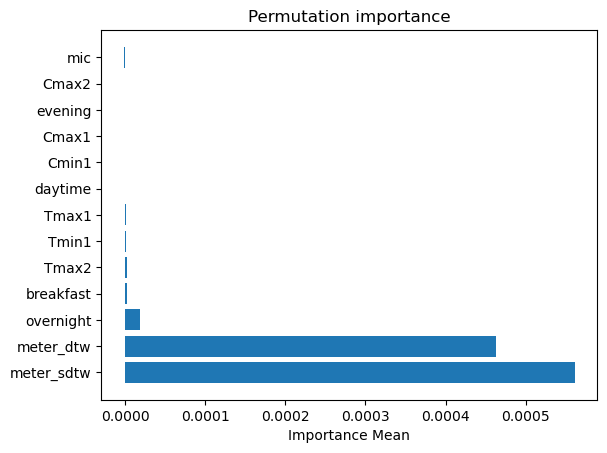

In [17]:
r = permutation_importance(model, result[col], result['FDI'], n_repeats=3, random_state=0, n_jobs=-1)
importance_dict = {}
for index, key in zip(range(len(col)), col):
    print(f'{key}: ', r.importances[index], r.importances_mean[index])
    importance_dict[key] = r.importances_mean[index]
plot_importance(importance_dict)

Saving figure Permutation importance: LinearSVM with 13 features(2)


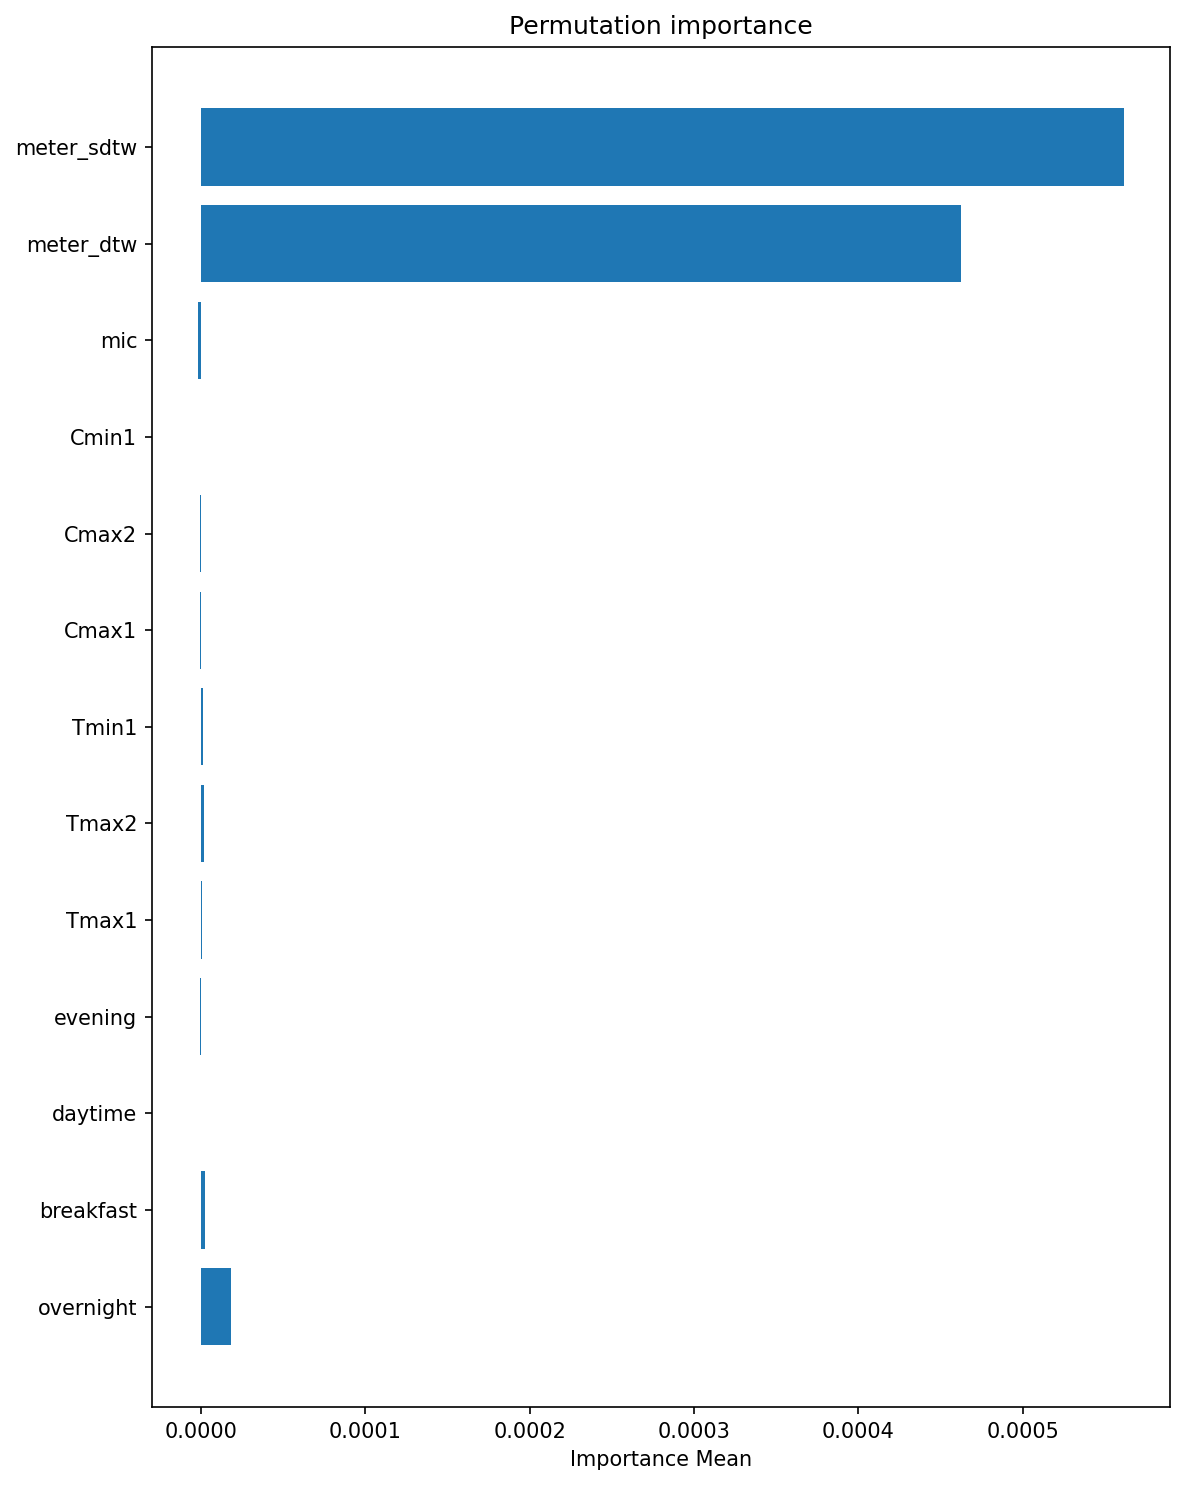

In [18]:
save_importance(importance_dict, "LinearSVM with 13 features(2)", size=(8,10))

## origin features

In [18]:
# 6:4 and seperate train and test dataset
# 48 features only
TITLE = "Adaboost: 48 features with 0.4 test data"
col = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47']
model, score = train_model(result, col, ['FDI'], return_model=True)



/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/pyt

average_precision_score: 0.0
average_recall_score: 0.0
average_accuracy_score: 0.9502369668246445
average_roc_auc_score: 0.5
average_f1_score: 0.0


0:  [0. 0. 0.] 0.0
1:  [0. 0. 0.] 0.0
2:  [0. 0. 0.] 0.0
3:  [0. 0. 0.] 0.0
4:  [0. 0. 0.] 0.0
5:  [0. 0. 0.] 0.0
6:  [0. 0. 0.] 0.0
7:  [0. 0. 0.] 0.0
8:  [0. 0. 0.] 0.0
9:  [0. 0. 0.] 0.0
10:  [0. 0. 0.] 0.0
11:  [0. 0. 0.] 0.0
12:  [0. 0. 0.] 0.0
13:  [0. 0. 0.] 0.0
14:  [0. 0. 0.] 0.0
15:  [0. 0. 0.] 0.0
16:  [0. 0. 0.] 0.0
17:  [0. 0. 0.] 0.0
18:  [0. 0. 0.] 0.0
19:  [0. 0. 0.] 0.0
20:  [0. 0. 0.] 0.0
21:  [0. 0. 0.] 0.0
22:  [0. 0. 0.] 0.0
23:  [0. 0. 0.] 0.0
24:  [0. 0. 0.] 0.0
25:  [0. 0. 0.] 0.0
26:  [0. 0. 0.] 0.0
27:  [0. 0. 0.] 0.0
28:  [0. 0. 0.] 0.0
29:  [0. 0. 0.] 0.0
30:  [0. 0. 0.] 0.0
31:  [0. 0. 0.] 0.0
32:  [0. 0. 0.] 0.0
33:  [0. 0. 0.] 0.0
34:  [0. 0. 0.] 0.0
35:  [0. 0. 0.] 0.0
36:  [0. 0. 0.] 0.0
37:  [0. 0. 0.] 0.0
38:  [0. 0. 0.] 0.0
39:  [0. 0. 0.] 0.0
40:  [0. 0. 0.] 0.0
41:  [0. 0. 0.] 0.0
42:  [0. 0. 0.] 0.0
43:  [0. 0. 0.] 0.0
44:  [0. 0. 0.] 0.0
45:  [0. 0. 0.] 0.0
46:  [0. 0. 0.] 0.0
47:  [0. 0. 0.] 0.0
Saving figure Permutation importance: LinearSVM wi

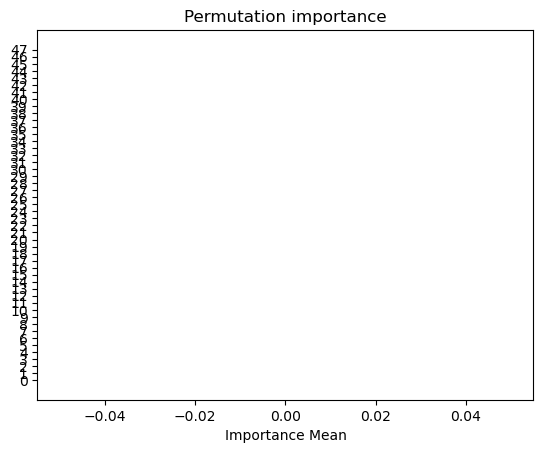

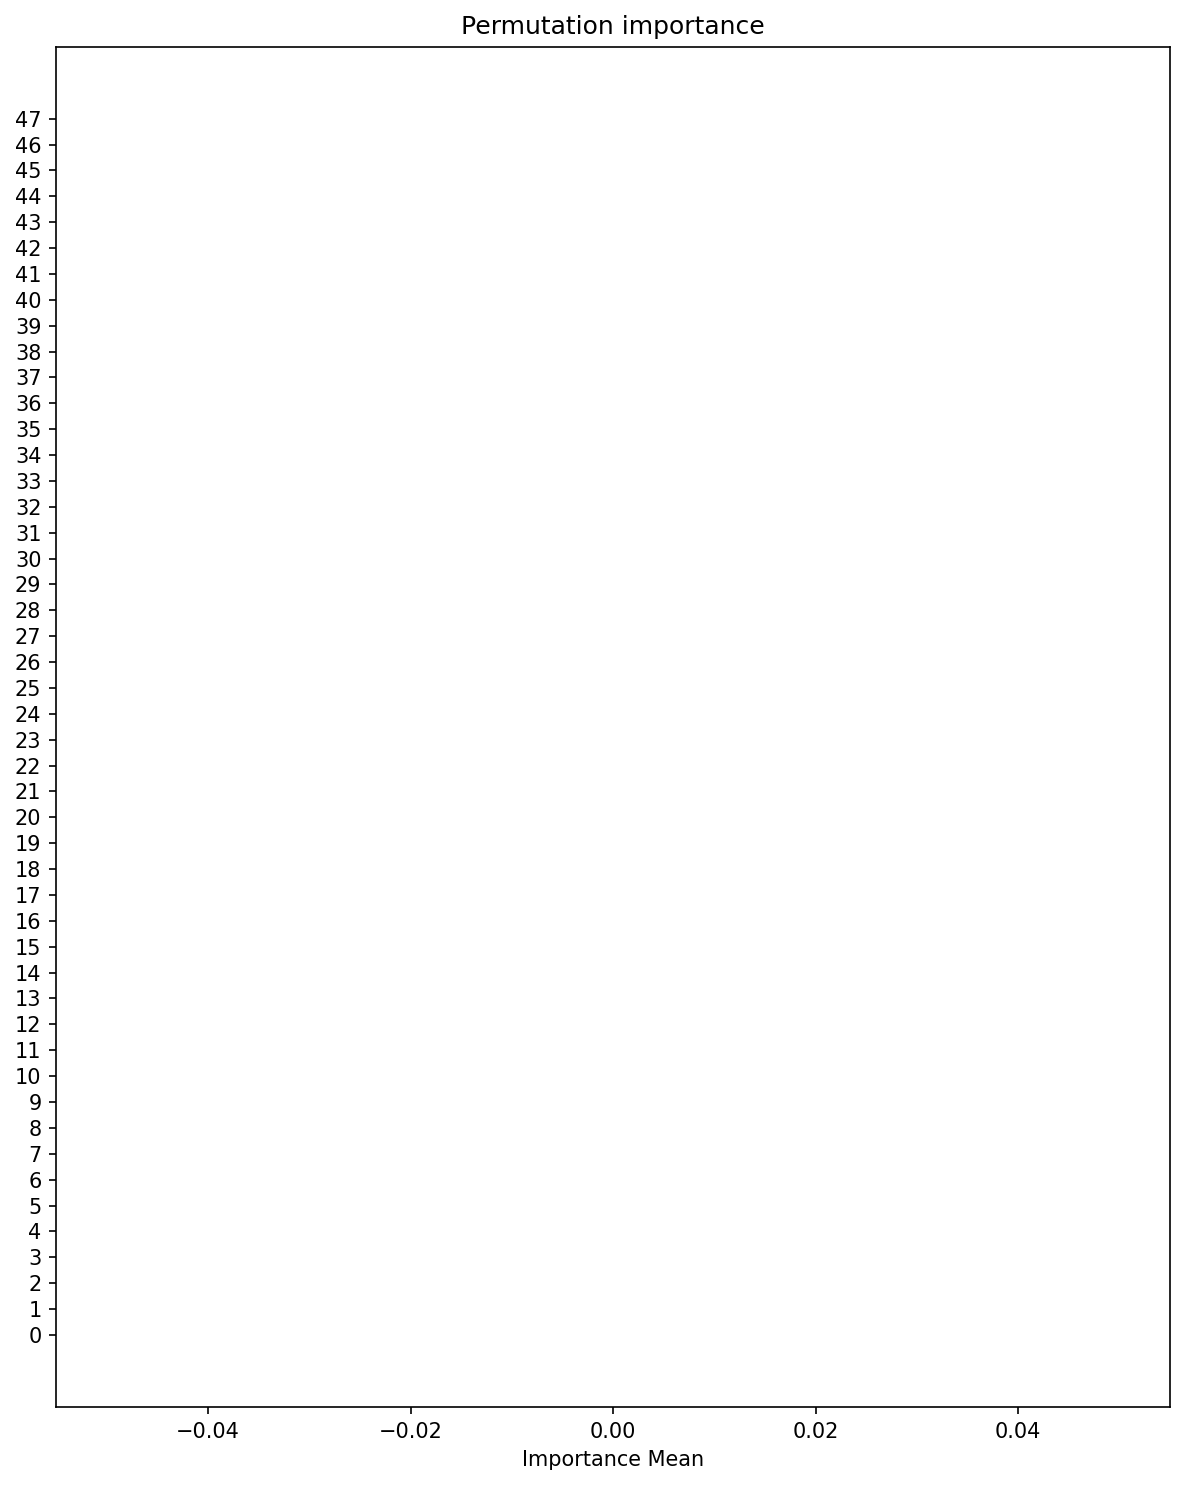

In [19]:
r = permutation_importance(model, result[col], result['FDI'], n_repeats=3, random_state=0, n_jobs=-1)
importance_dict = {}
for index, key in zip(range(len(col)), col):
    print(f'{key}: ', r.importances[index], r.importances_mean[index])
    importance_dict[key] = r.importances_mean[index]
plot_importance(importance_dict)

save_importance(importance_dict, "LinearSVM with 48 features", size=(8,10))

## all features

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


average_precision_score: 0.011930199430199429
average_recall_score: 8.319190709127816e-05
average_accuracy_score: 0.9499111581401665
average_roc_auc_score: 0.4998679821195074
average_f1_score: 0.00016473603362289555
Tmax1:  [0. 0. 0.] 0.0
Tmax2:  [-4.46578095e-07  0.00000000e+00  0.00000000e+00] -1.4885936513072315e-07
Tmin1:  [ 0.00000000e+00 -8.93156191e-07 -8.93156191e-07] -5.954374605228926e-07
Cmax1:  [ 0.00000000e+00 -4.46578095e-07 -4.46578095e-07] -2.977187302614463e-07
Cmax2:  [-4.46578095e-07  0.00000000e+00  0.00000000e+00] -1.4885936513072315e-07
Cmin1:  [ 0.00000000e+00 -4.46578095e-07 -4.46578095e-07] -2.977187302614463e-07
overnight:  [0.00187116 0.00186759 0.00188054] 0.001873097391239605
breakfast:  [1.78631238e-06 1.78631238e-06 1.78631238e-06] 1.786312381346633e-06
daytime:  [0.00148934 0.00149336 0.0014947 ] 0.0014924639946409801
evening:  [0. 0. 0.] 0.0
mic:  [-4.46578095e-07 -8.93156191e-07  0.00000000e+00] -4.465780953921694e-07
meter_dtw:  [8.12772134e-05 8.3956

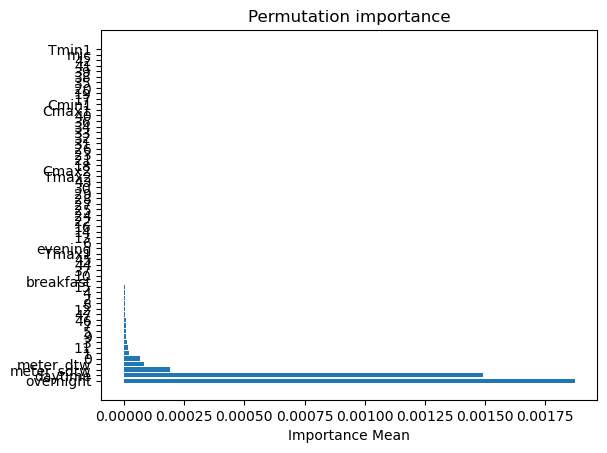

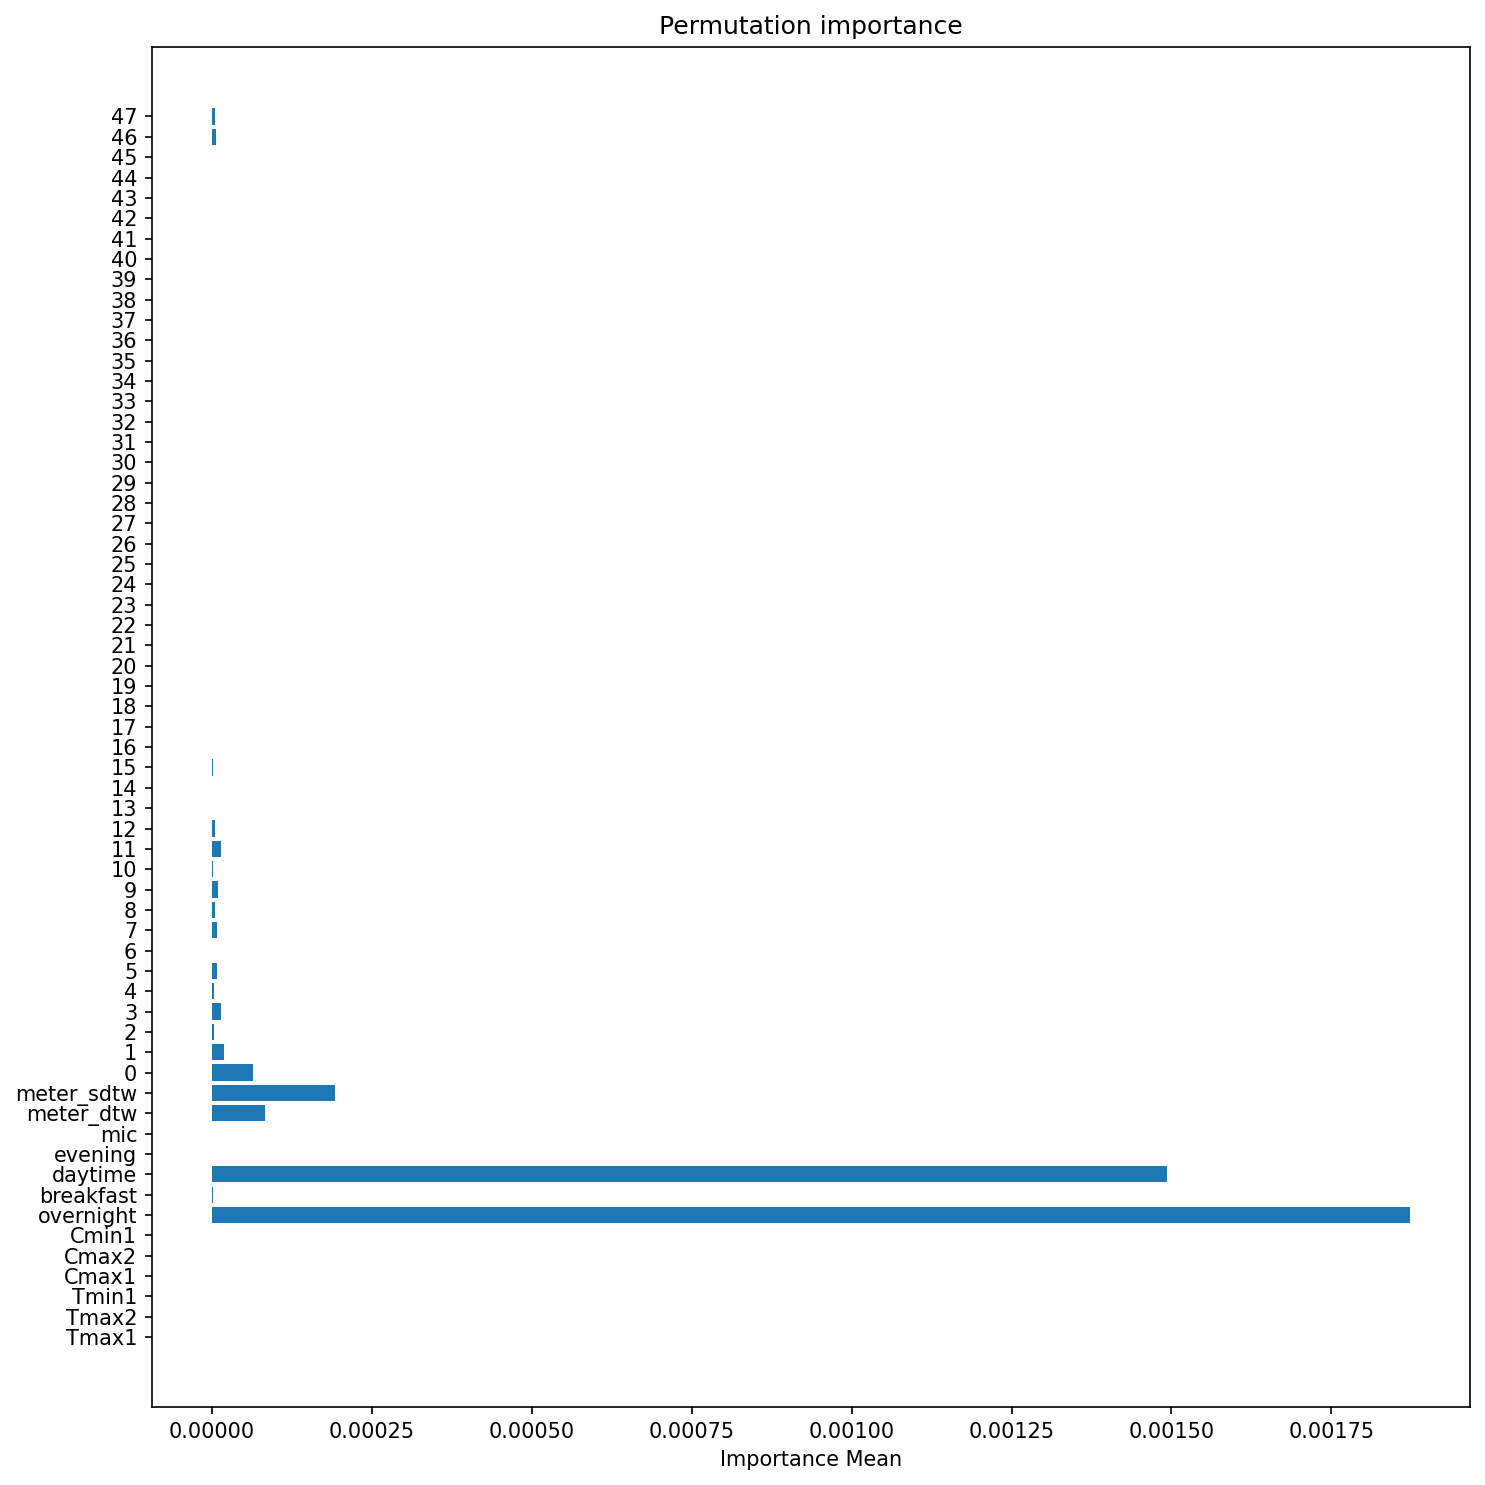

In [20]:
# 6:4 and seperate train and test dataset
# 13 + 48 features
TITLE = "LinearSVM: 13 + 48 features with 0.4 test data"
col = result.drop(['Day', 'MeterID', 'FDI'], axis=1).columns
model, score = train_model(result, col, ['FDI'], return_model=True)

r = permutation_importance(model, result[col], result['FDI'], n_repeats=3, random_state=0, n_jobs=-1)
importance_dict = {}
for index, key in zip(range(len(col)), col):
    print(f'{key}: ', r.importances[index], r.importances_mean[index])
    importance_dict[key] = r.importances_mean[index]
plot_importance(importance_dict)

save_importance(importance_dict, "LinearSVM with 13 + 48 features", size=(10,10))

In [19]:
# 6:4 and seperate train and test dataset
# 13 features
TITLE = "LinearSVM with 13 features"
col = ['overnight', 'breakfast', 'daytime', 'evening',
       'Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2', 'Cmin1', 'mic',
       'meter_dtw', 'meter_sdtw']
start_time = timer(None) 
model, score = train_model(result, col, ['FDI'], return_model=True)
timer(start_time)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


average_precision_score: 0.0842911877394636
average_recall_score: 4.99151442547669e-05
average_accuracy_score: 0.9497670902593552
average_roc_auc_score: 0.49977640878337254
average_f1_score: 9.854779640951607e-05

 Time taken: 0 hours 24 minutes and 7.85 seconds.


In [ ]:
r = permutation_importance(model, result[col], result['FDI'], n_repeats=3, random_state=0, n_jobs=-1)
importance_dict = {}
for index, key in zip(range(len(col)), col):
    print(f'{key}: ', r.importances[index], r.importances_mean[index])
    importance_dict[key] = r.importances_mean[index]
plot_importance(importance_dict)

In [ ]:
save_importance(importance_dict, "LinearSVM with 13 features", size=(8,10))

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


average_precision_score: 0.0
average_recall_score: 0.0
average_accuracy_score: 0.9501980519372989
average_roc_auc_score: 0.49997952358795533
average_f1_score: 0.0
no origin data
Saving figure Permutation importance: LinearSVM: 13 features with 0.4 test data


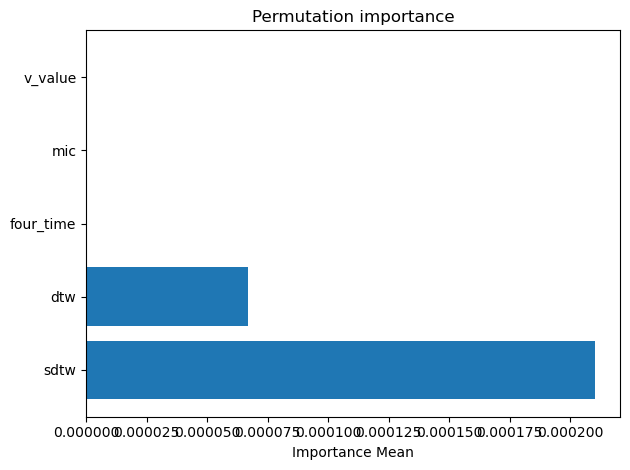

In [12]:
# 6:4 and seperate train and test dataset
# 13 features
TITLE = "LinearSVM: 13 features with 0.4 test data"
col = ['overnight', 'breakfast', 'daytime', 'evening',
       'Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2', 'Cmin1', 'mic',
       'meter_dtw', 'meter_sdtw']
model, score = train_model(result, col, ['FDI'], return_model=True)
get_permutation_importance(model, result[col][partition:], result['FDI'][partition:], title= TITLE, save=True)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


average_precision_score: 0.02796674225245654
average_recall_score: 0.0012312402249509168
average_accuracy_score: 0.9495596821895668
average_roc_auc_score: 0.5002270039519683
average_f1_score: 0.00235864091285778
include origin data
Saving figure Permutation importance: LinearSVM: 13 + 48 features with 0.4 test data


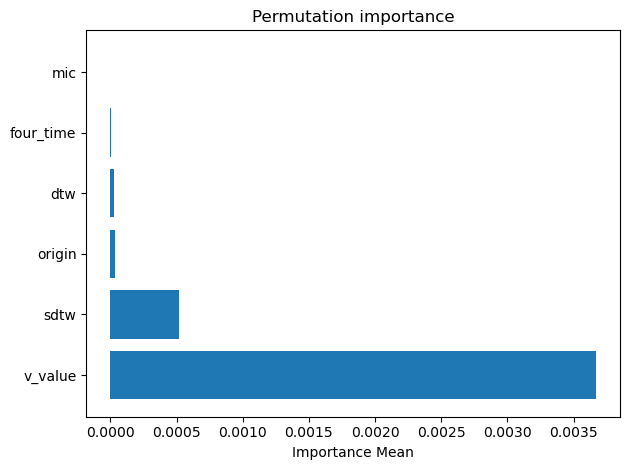

In [13]:
# 6:4 and seperate train and test dataset
# 13 + 48 features
TITLE = "LinearSVM: 13 + 48 features with 0.4 test data"
col = result.drop(['Day', 'MeterID', 'FDI'], axis=1).columns
model, score = train_model(result, col, ['FDI'], return_model=True)
get_permutation_importance(model, result[col][partition:], result['FDI'][partition:], title= TITLE, origin=True,save=True)

## old(all meter is false)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


average_precision_score: 0.03600522836780596
average_recall_score: 0.3116202455825097
average_accuracy_score: 0.6602883510354672
average_roc_auc_score: 0.505222798873494
average_f1_score: 0.06172758283305967
no origin data
Saving figure Permutation importance: LinearSVM: 13 features with 0.4 test data


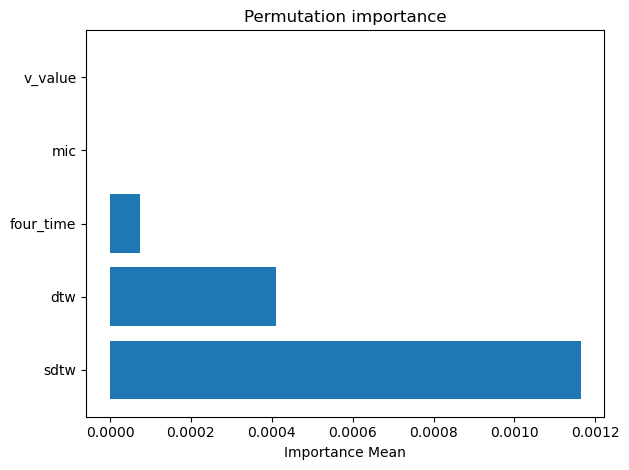

In [15]:
# 6:4 and seperate train and test dataset
# 13 features
TITLE = "LinearSVM: 13 features with 0.4 test data"
col = ['overnight', 'breakfast', 'daytime', 'evening',
       'Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2', 'Cmin1', 'mic',
       'meter_dtw', 'meter_sdtw']
model, score = train_model(result, col, ['FDI'], return_model=True)
get_permutation_importance(model, result[col][partition:], result['FDI'][partition:], title= TITLE, save=True)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


average_precision_score: 0.01265022137887413
average_recall_score: 0.0002495757212738345
average_accuracy_score: 0.8997999609195174
average_roc_auc_score: 0.4997367632918775
average_f1_score: 0.0004894942300867629
include origin data
Saving figure Permutation importance: LinearSVM: 13 + 48 features with 0.4 test data


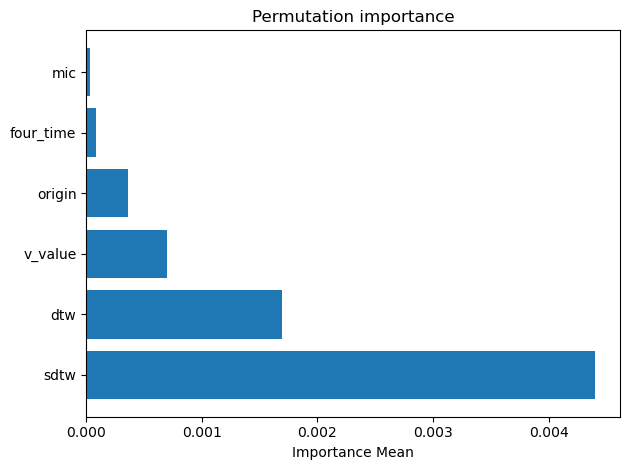

In [17]:
# 6:4 and seperate train and test dataset
# 13 + 48 features
TITLE = "LinearSVM: 13 + 48 features with 0.4 test data"
col = result.drop(['Day', 'MeterID', 'FDI'], axis=1).columns
model, score = train_model(result, col, ['FDI'], return_model=True)
get_permutation_importance(model, result[col][partition:], result['FDI'][partition:], title= TITLE, origin=True,save=True)

## SVM

In [13]:
def train_model(df, x_col, y_col, score = False, split_num = 3, return_model=False ):
    
    X = df[x_col]
    Y = df[y_col]

    partition = 422*8*530
    evaluation = 422*1*530
    total = 2239250

    round = 1
    average_score = {}
    average_score["precision_score"] = 0
    average_score["recall_score"] = 0
    average_score["accuracy_score"] = 0
    average_score["roc_auc_score"] = 0
    average_score["f1_score"] = 0

    X_train = X[:partition+evaluation]
    y_train = Y[:partition+evaluation]

    sss = StratifiedShuffleSplit(n_splits=split_num, test_size=0.4, random_state=1)
    for train_index, test_index in sss.split(X_train, y_train):
#         test_index = np.concatenate((np.array(test_index), np.array(X[total-(partition+evaluation): total].index)))
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = np.array(Y.iloc[train_index]).reshape(-1) , np.array(Y.iloc[test_index]).reshape(-1)

        model = SVC()
        model.fit(X_train, Y_train)
        y_hat = model.predict(X_test)
        average_score["precision_score"] += precision_score(Y_test, y_hat)
        average_score["recall_score"] += recall_score(Y_test, y_hat)
        average_score["accuracy_score"] += accuracy_score(Y_test, y_hat)
        average_score["roc_auc_score"] += roc_auc_score(Y_test, y_hat)
        average_score["f1_score"] += f1_score(Y_test, y_hat)

        if score:
            print("round: " + str(round))
            print("precision score: " + str(precision_score(Y_test, y_hat)))
            print("recall_score: " + str(recall_score(Y_test, y_hat)))
            print("accuracy_score: " + str(accuracy_score(Y_test, y_hat)))
            print("roc_auc_score: " + str(roc_auc_score(Y_test, y_hat)))
            print("f1_score: " + str(f1_score(Y_test, y_hat)))
            print()

        round += 1
    for key, score in average_score.items():
        average_score[key] = score / split_num
        print("average_" + key + ": " + str(average_score[key]))
    if return_model==True:
        return model, average_score
    return average_score

In [ ]:
# 6:4 and seperate train and test dataset
# 13 features
TITLE = "SVM: 13 features with 0.4 test data"
col = ['overnight', 'breakfast', 'daytime', 'evening',
       'Tmax1', 'Tmax2', 'Tmin1', 'Cmax1', 'Cmax2', 'Cmin1', 'mic',
       'meter_dtw', 'meter_sdtw']
model, score = train_model(result, col, ['FDI'], return_model=True)
get_permutation_importance(model, result[col][partition:], result['FDI'][partition:], title= TITLE, save=True)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model, score

In [ ]:
# 6:4 and seperate train and test dataset
# 13 + 48 features
TITLE = "SVM: 13 + 48 features with 0.4 test data"
col = result.drop(['Day', 'MeterID', 'FDI'], axis=1).columns
model, score = train_model(result, col, ['FDI'], return_model=True)
get_permutation_importance(model, result[col][partition:], result['FDI'][partition:], title= TITLE, origin=True, save=True)

In [ ]:
1